uncomment and run the below cell to install required packages if necessary else skip

In [1]:

!pip install scipy scikit-learn matplotlib pandas


<h2><b>Importing necessary libraries</h2>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

from sklearn.datasets import load_digits
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy



<h2><b>Load  and visualise the Digits dataset</b></h2>

Dataset: Digits
Total number of samples: 1797
Shape of images: 64 (8x8 pixel images flattened to 64 features)
Number of classes: 10 (digits 0-9)
Dtype of images: float64
Dtype of labels: int64


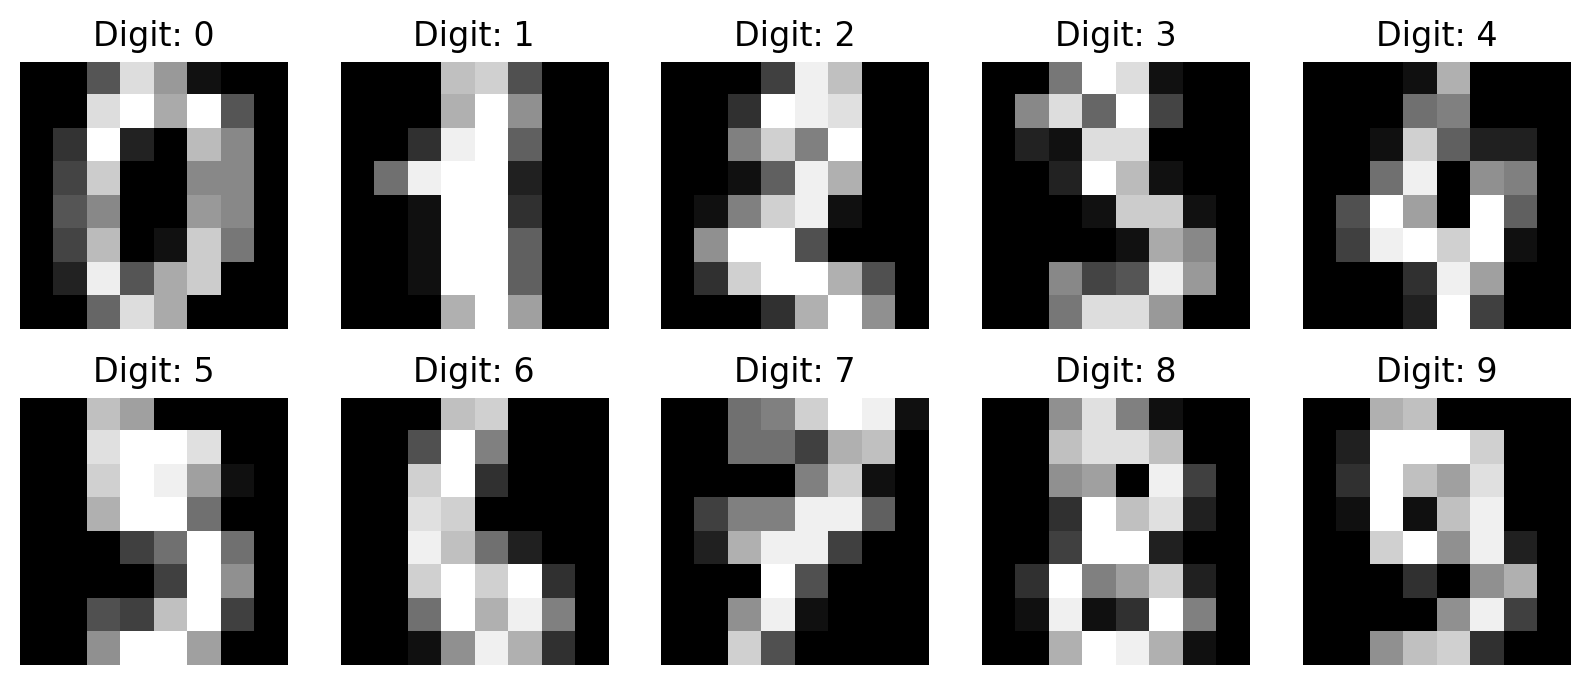

In [3]:

digits = load_digits()
X, y = digits.data, digits.target


print("Dataset: Digits")
print(f"Total number of samples: {len(X)}")
print(f"Shape of images: {X.shape[1]} (8x8 pixel images flattened to 64 features)")
print(f"Number of classes: {len(np.unique(y))} (digits 0-9)")
print(f"Dtype of images: {X.dtype}")
print(f"Dtype of labels: {y.dtype}")


fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Digit: {y[i]}")
    ax.axis('off')
plt.show()

<h2><b>Split the Dataset</h2>

In [4]:
def load_and_split_data():

    digits = load_digits()
    X, y = digits.data, digits.target


    scaler = StandardScaler()
    X = scaler.fit_transform(X)


    indices = np.random.permutation(len(X))
    train_idx = indices[:1297]
    test_idx = indices[1297:]

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    train_indices = np.random.permutation(len(X_train))
    labeled_indices = train_indices[:100]
    pool_indices = train_indices[100:]

    X_labeled = X_train[labeled_indices]
    y_labeled = y_train[labeled_indices]
    X_pool = X_train[pool_indices]
    y_pool = y_train[pool_indices]


    print(f"Initial labeled set size: {len(X_labeled)}")
    print(f"Pool set size: {len(X_pool)}")
    print(f"Test set size: {len(X_test)}")

    return X_labeled, y_labeled, X_pool, y_pool, X_train, y_train, X_test, y_test, scaler

X_labeled, y_labeled, X_pool, y_pool, X_train, y_train, X_test, y_test, scaler = load_and_split_data()

Initial labeled set size: 100
Pool set size: 1197
Test set size: 500


<h2><b>Defining Acquisition Function</h2>
<h4> <b> 1. Random Sampling</h4>

### Random Sampling

Random sampling is the simplest active learning strategy. It selects samples **uniformly at random** from the unlabeled data pool without considering the model's uncertainty or predictions.

- Given an unlabeled pool

$$
\mathcal{X} = \{ x_1, x_2, \ldots, x_N \}
$$

- Randomly select $n$ samples from $\mathcal{X}$ without replacement.


$$
x^* = \text{random samples from } \mathcal{X}
$$

This method is easy to implement and serves as a baseline to compare more advanced active learning strategies.


In [5]:
def random_sampling(model, X_pool, num_samples):
    indices = np.random.choice(len(X_pool), num_samples, replace=False)
    return indices





### Entropy Sampling

Entropy sampling is an uncertainty-based active learning strategy. It selects data points from the unlabeled pool for which the model's predictions have the **highest uncertainty**, measured using **Shannon entropy**.

Let the predicted class probabilities for a sample $x$ be:

$$
P(y_1 \mid x), P(y_2 \mid x), \ldots, P(y_C \mid x)
$$

Then the **entropy** for that prediction is defined as:

$$
H(x) = - \sum_{i=1}^{C} P(y_i \mid x) \cdot \log P(y_i \mid x)
$$

Where:
- $C$ is the number of classes
- $P(y_i \mid x)$ is the predicted probability for class $i$

**Selection Rule**:

$$
x^* = \arg\max_x H(x)
$$

That is, select the samples with the **highest entropy**, which indicates **maximum uncertainty**.

Higher entropy means the model is more unsure about which class to choose — so labeling these samples will likely provide the most learning benefit.


In [6]:
def entropy_sampling(model, X_pool, num_samples):
    probs = model.predict_proba(X_pool)
    entropies = entropy(probs.T)
    indices = np.argsort(entropies)[-num_samples:]
    return indices

### Margin Sampling

Margin sampling is an uncertainty-based strategy that selects data points where the model is least confident — specifically, where the difference between the top two predicted class probabilities is smallest.

**Formula**:

Let the predicted class probabilities for a sample \( x \) be:

$$
P(y_1 \mid x),\; P(y_2 \mid x),\; \ldots,\; P(y_C \mid x)
$$

Let:$$
P_{(1)}: \text{highest class probability}
$$

$$
P_{(2)}: \text{second highest class probability}
$$



Then the **margin** is:

$$
\text{Margin}(x) = P_{(1)} - P_{(2)}
$$

**Selection Rule**:

$$
x^* = \arg\min_x \left( P_{(1)} - P_{(2)} \right)
$$

Lower margins indicate higher uncertainty and are prioritized for labeling.


In [7]:
def margin_sampling(model, X_pool, num_samples):
    probs = model.predict_proba(X_pool)
    top2_probs = np.partition(probs, -2, axis=1)[:, -2:]
    margins = top2_probs[:, 1] - top2_probs[:, 0]
    indices = np.argsort(margins)[:num_samples]
    return indices

<h2><b>Computing results on intial dataset</b></h2>

In [8]:
def compute_baselines(X_labeled, y_labeled, X_pool, y_pool, X_train, y_train, X_test, y_test):

    model = MLPClassifier(
        hidden_layer_sizes=(20,),
        max_iter=2000,
        learning_rate_init=0.01,
        early_stopping=True,
        random_state=42
    )


    model.fit(X_labeled, y_labeled)
    accuracy_only_train = accuracy_score(y_test, model.predict(X_test))
    print(f"Baseline - Only train accuracy: {accuracy_only_train:.4f}")


    X_all = np.concatenate([X_labeled, X_pool])
    y_all = np.concatenate([y_labeled, y_pool])
    model.fit(X_all, y_all)
    accuracy_train_plus_pool = accuracy_score(y_test, model.predict(X_test))
    print(f"Baseline - Train + pool accuracy: {accuracy_train_plus_pool:.4f}")



    return accuracy_only_train, accuracy_train_plus_pool

accuracy_only_train, accuracy_train_plus_pool = compute_baselines(X_labeled, y_labeled, X_pool, y_pool, X_train, y_train, X_test, y_test)

Baseline - Only train accuracy: 0.7620
Baseline - Train + pool accuracy: 0.9640


<h1><b>Active Learning Loop</b></h1>

<img src = "https://miro.medium.com/v2/resize:fit:4800/format:webp/1*oxdGbn2eao-lUjsowN8L9w.png">
<center>

In [9]:
def run_active_learning(X_labeled, y_labeled, X_pool, y_pool, X_train, y_train, X_test, y_test, strategy_fn, strategy_name, strat_type, num_iterations=500, samples_per_iteration=1):
    X_labeled_run = X_labeled.copy()
    y_labeled_run = y_labeled.copy()
    X_pool_run = X_pool.copy()
    y_pool_run = y_pool.copy()
    accuracies = []

    for iteration in range(num_iterations):
        model = MLPClassifier(
            hidden_layer_sizes=(20,),
            max_iter=2000,
            learning_rate_init=0.01,
            early_stopping=True,
            random_state=42
        )
        model.fit(X_labeled_run, y_labeled_run)

        test_acc = accuracy_score(y_test, model.predict(X_test))
        accuracies.append(test_acc)

        remaining_samples = len(X_pool_run)
        if remaining_samples == 0:
            accuracies.extend([test_acc] * (num_iterations - len(accuracies)))
            print(f"Iteration {iteration + 1}: Labeled set size: {len(X_labeled_run)}, Pool set size: {len(X_pool_run)}")
            break

        num_samples = min(samples_per_iteration, remaining_samples)
        indices = strategy_fn(model, X_pool_run, num_samples)
        X_query = X_pool_run[indices]
        y_query = y_pool_run[indices]

        X_labeled_run = np.concatenate([X_labeled_run, X_query])
        y_labeled_run = np.concatenate([y_labeled_run, y_query])

        mask = np.ones(len(X_pool_run), dtype=bool)
        mask[indices] = False
        X_pool_run = X_pool_run[mask]
        y_pool_run = y_pool_run[mask]


        # print(f"Iteration {iteration + 1}: Labeled set size: {len(X_labeled_run)}, Pool set size: {len(X_pool_run)}")


    final_model = MLPClassifier(
        hidden_layer_sizes=(20,),
        max_iter=2000,
        learning_rate_init=0.01,
        early_stopping=True,
        random_state=42
    )
    final_model.fit(X_labeled_run, y_labeled_run)


    train_acc = accuracy_score(y_train, final_model.predict(X_train))
    test_acc = accuracy_score(y_test, final_model.predict(X_test))
    pool_acc = accuracy_score(y_pool, final_model.predict(X_pool)) if len(X_pool_run) > 0 else "Pool exhausted"
    print(f"\nStrategy: {strategy_name}")

    print(f"Final model - Test accuracy: {test_acc:.4f}")



    y_pred = final_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {strategy_name}")
    plt.show()

    return accuracies, final_model

<h2><b>Making Acquisition Function List</b></h2>

In [10]:

strategies = {
    'Random sampling': random_sampling,
    'Entropy sampling': entropy_sampling,
    'Margin sampling': margin_sampling
}



<h2>Acquistion Function 1: <b>Random Sampling</b></h2>


Running strategy: Random sampling

Strategy: Random sampling
Final model - Test accuracy: 0.9200


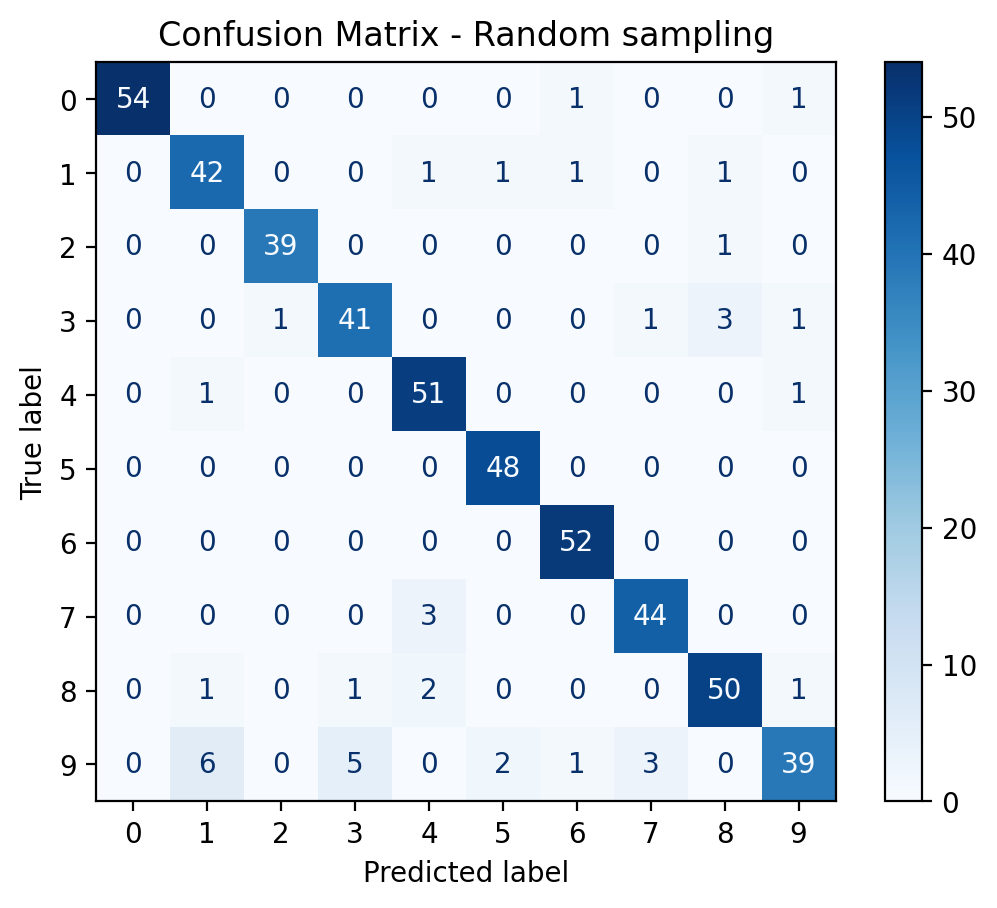


Strategy: Random sampling
Final model - Test accuracy: 0.9340


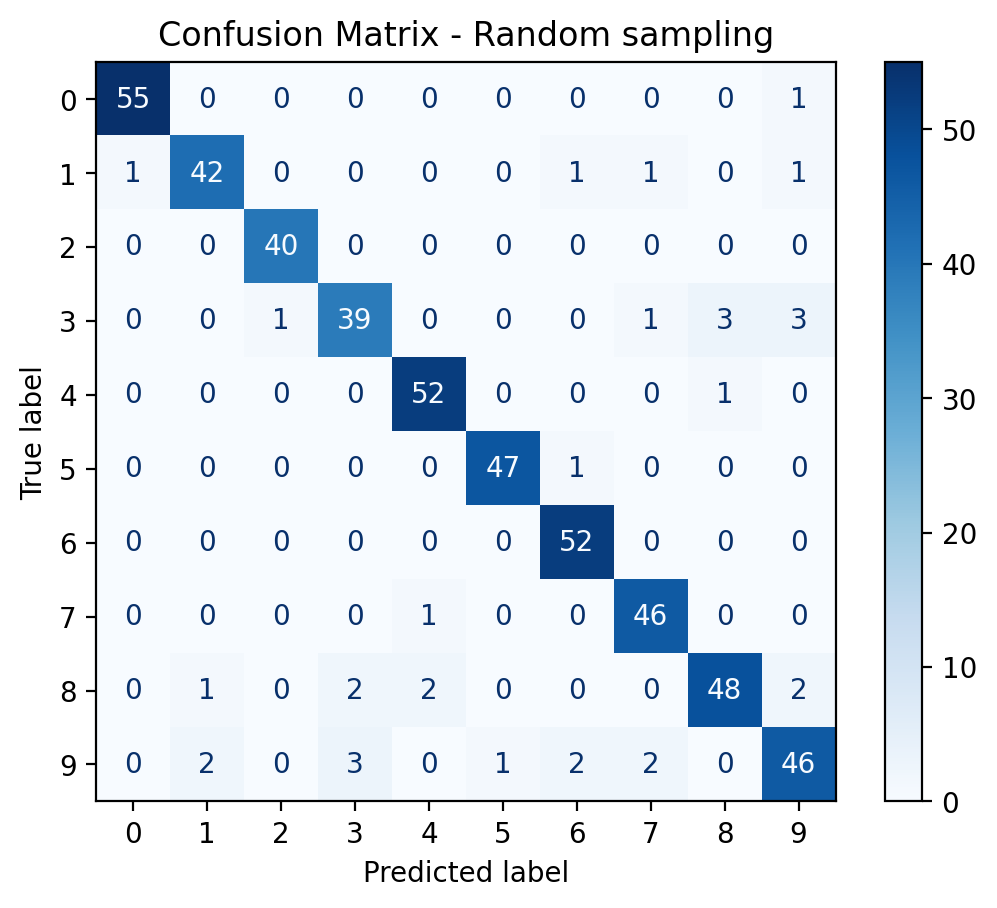


Strategy: Random sampling
Final model - Test accuracy: 0.9360


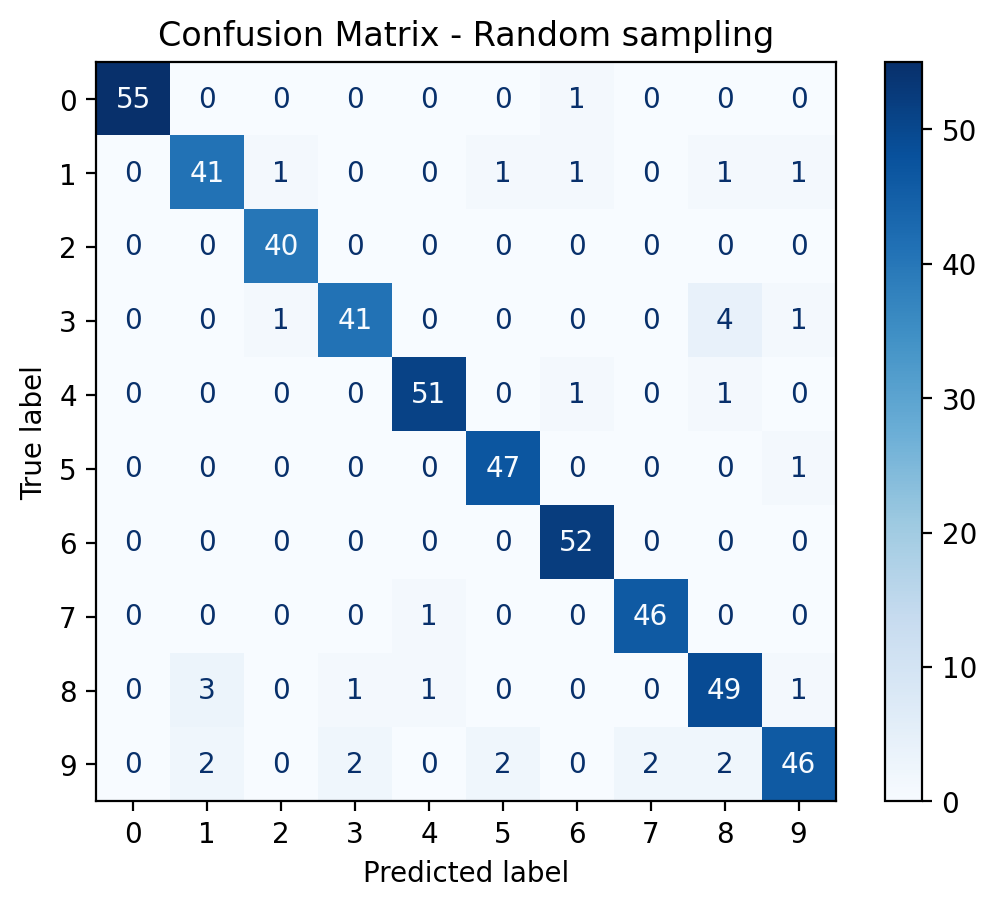


Strategy: Random sampling
Final model - Test accuracy: 0.9180


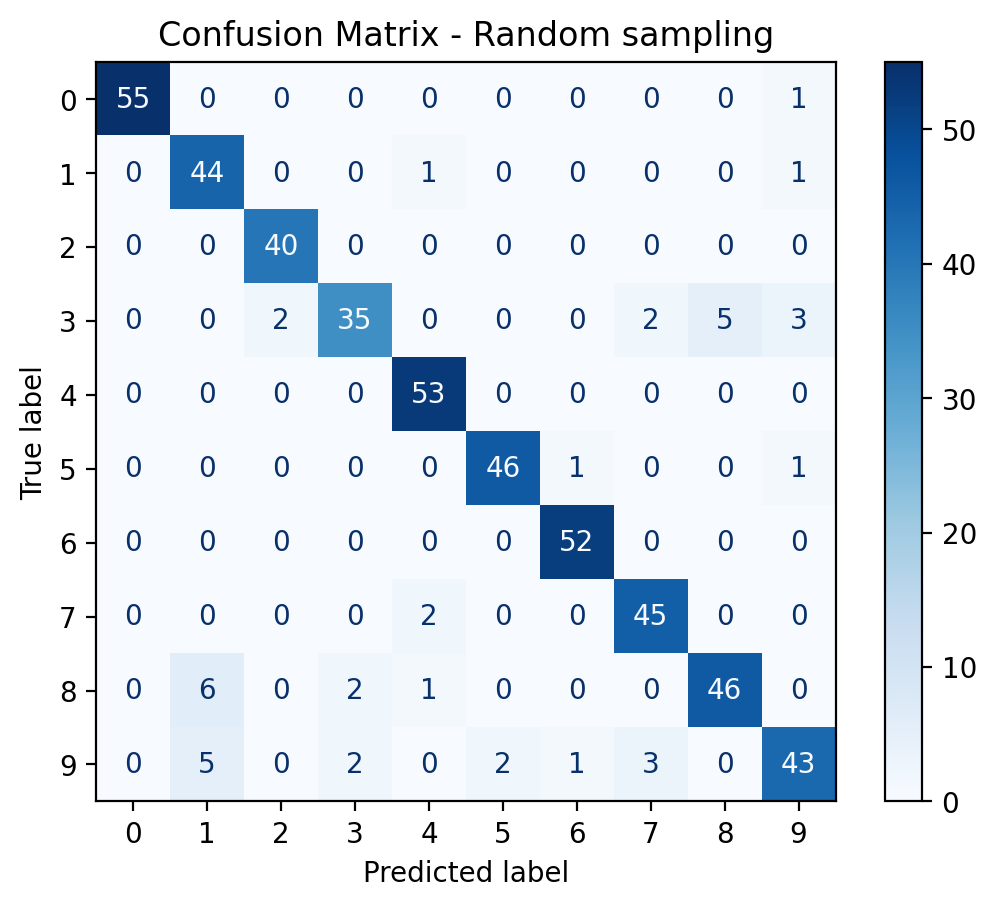


Strategy: Random sampling
Final model - Test accuracy: 0.9300


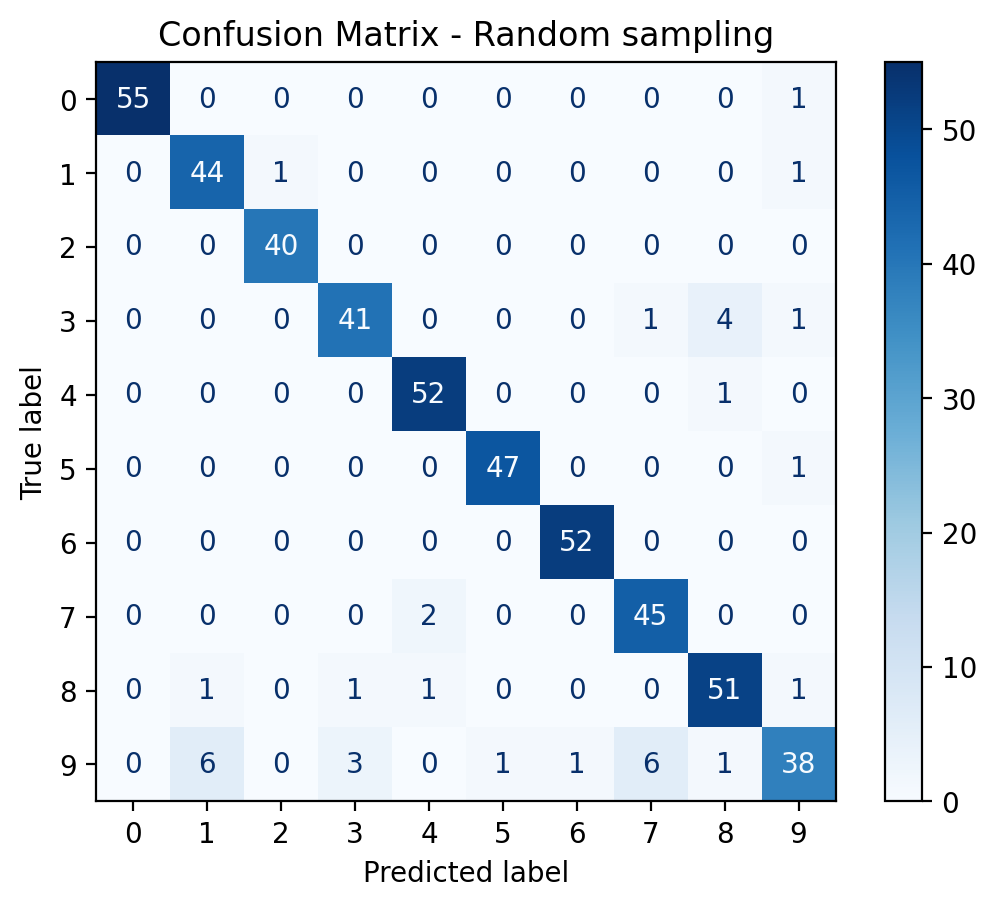

In [11]:

num_iterations = 500
num_runs = 5
results = {name: [] for name in strategies.keys()}
strategy_name = 'Random sampling'
strategy_fn = strategies[strategy_name]
random_results = []

print(f"\nRunning strategy: {strategy_name}")
for run in range(num_runs):

    accuracies, _ = run_active_learning(X_labeled, y_labeled, X_pool.copy(), y_pool.copy(), X_train, y_train, X_test, y_test,
                                       strategy_fn, strategy_name, strat_type=None, num_iterations=500, samples_per_iteration=1)
    random_results.append(accuracies)

random_results = np.array(random_results)

actual_iterations = random_results.shape[1]


mean_acc = pd.Series(random_results.mean(axis=0), index=range(actual_iterations))
std_acc = pd.Series(random_results.std(axis=0), index=range(actual_iterations))
results['Random sampling'] = mean_acc
print("\n")

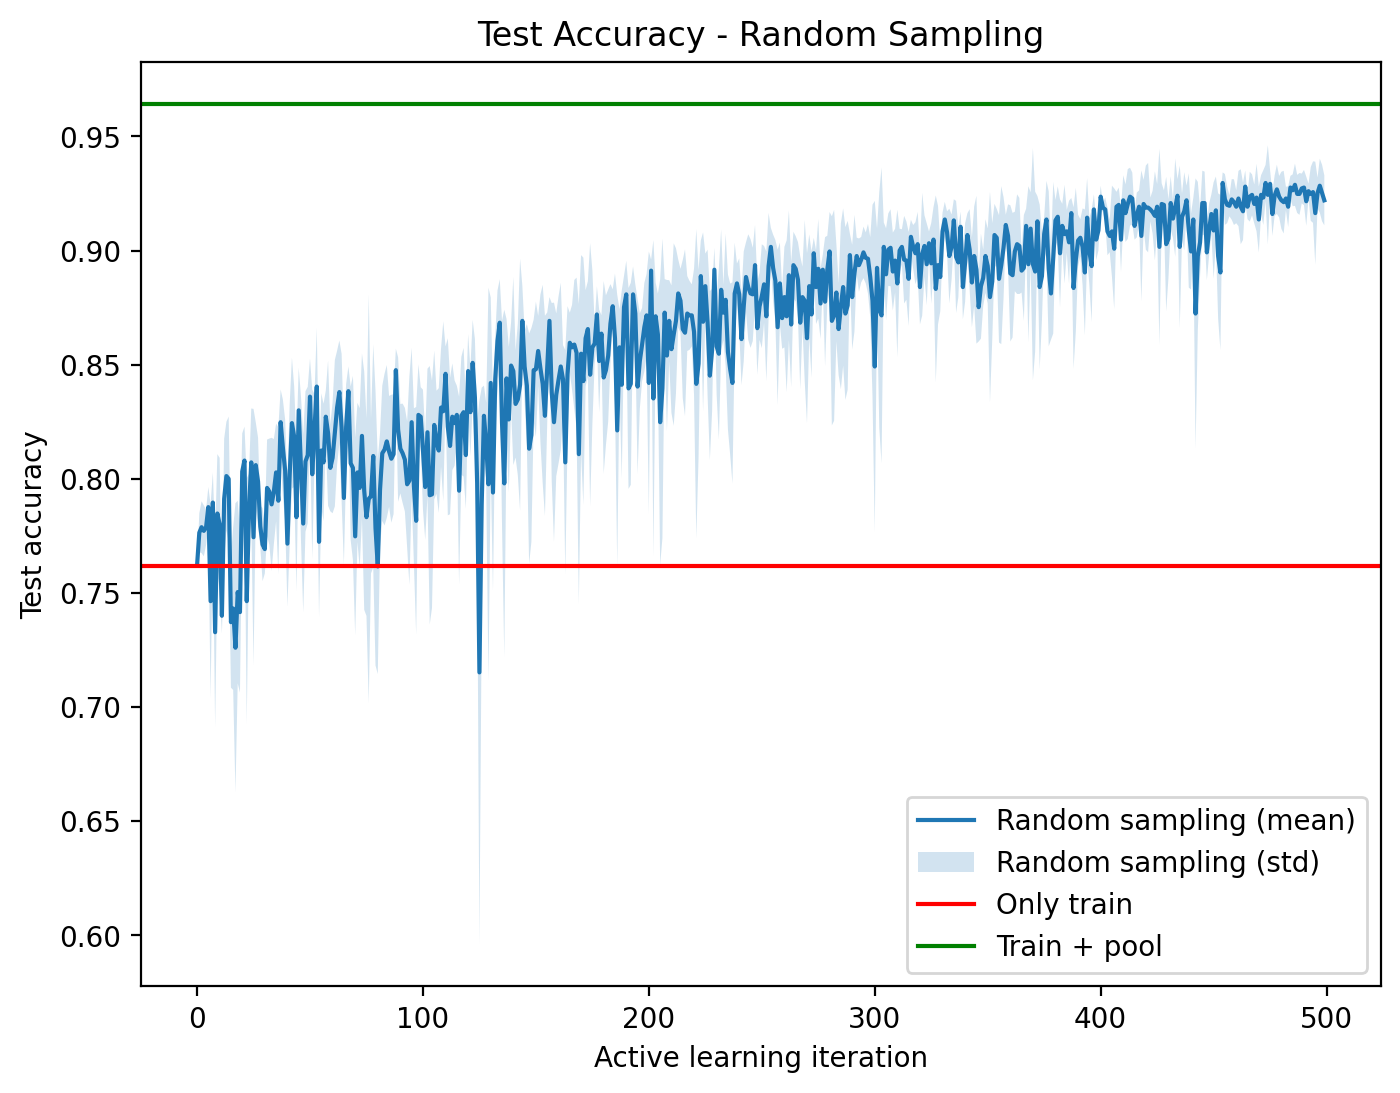

In [12]:

plt.figure(figsize=(8, 6))
plt.plot(mean_acc, label="Random sampling (mean)")
plt.fill_between(mean_acc.index, mean_acc-std_acc, mean_acc+std_acc, alpha=0.2, label="Random sampling (std)")
plt.axhline(accuracy_only_train, color='r', label='Only train')
plt.axhline(accuracy_train_plus_pool, color='g', label='Train + pool')
plt.xlabel("Active learning iteration")
plt.ylabel("Test accuracy")
plt.title("Test Accuracy - Random Sampling")
plt.legend()
plt.show()

<h2>Acquistion Function 2: <b>Entropy</b></h2>


Running strategy: Entropy sampling

Strategy: Entropy sampling
Final model - Test accuracy: 0.9580


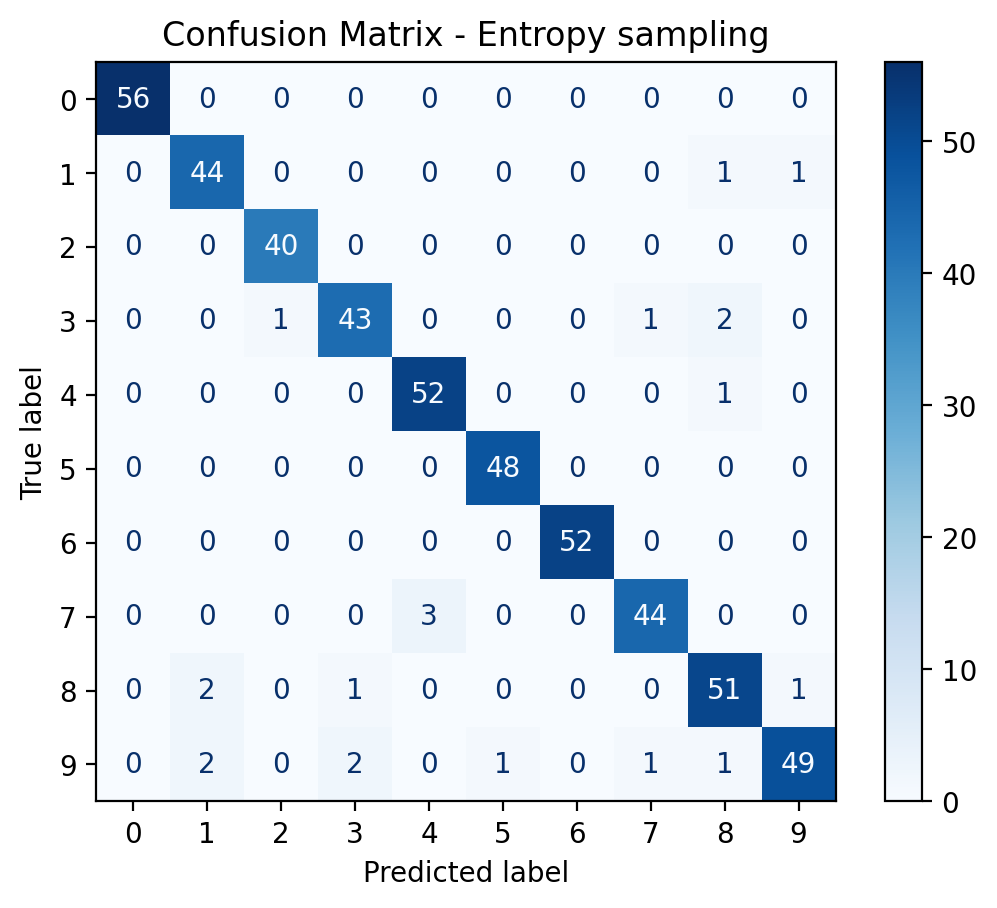

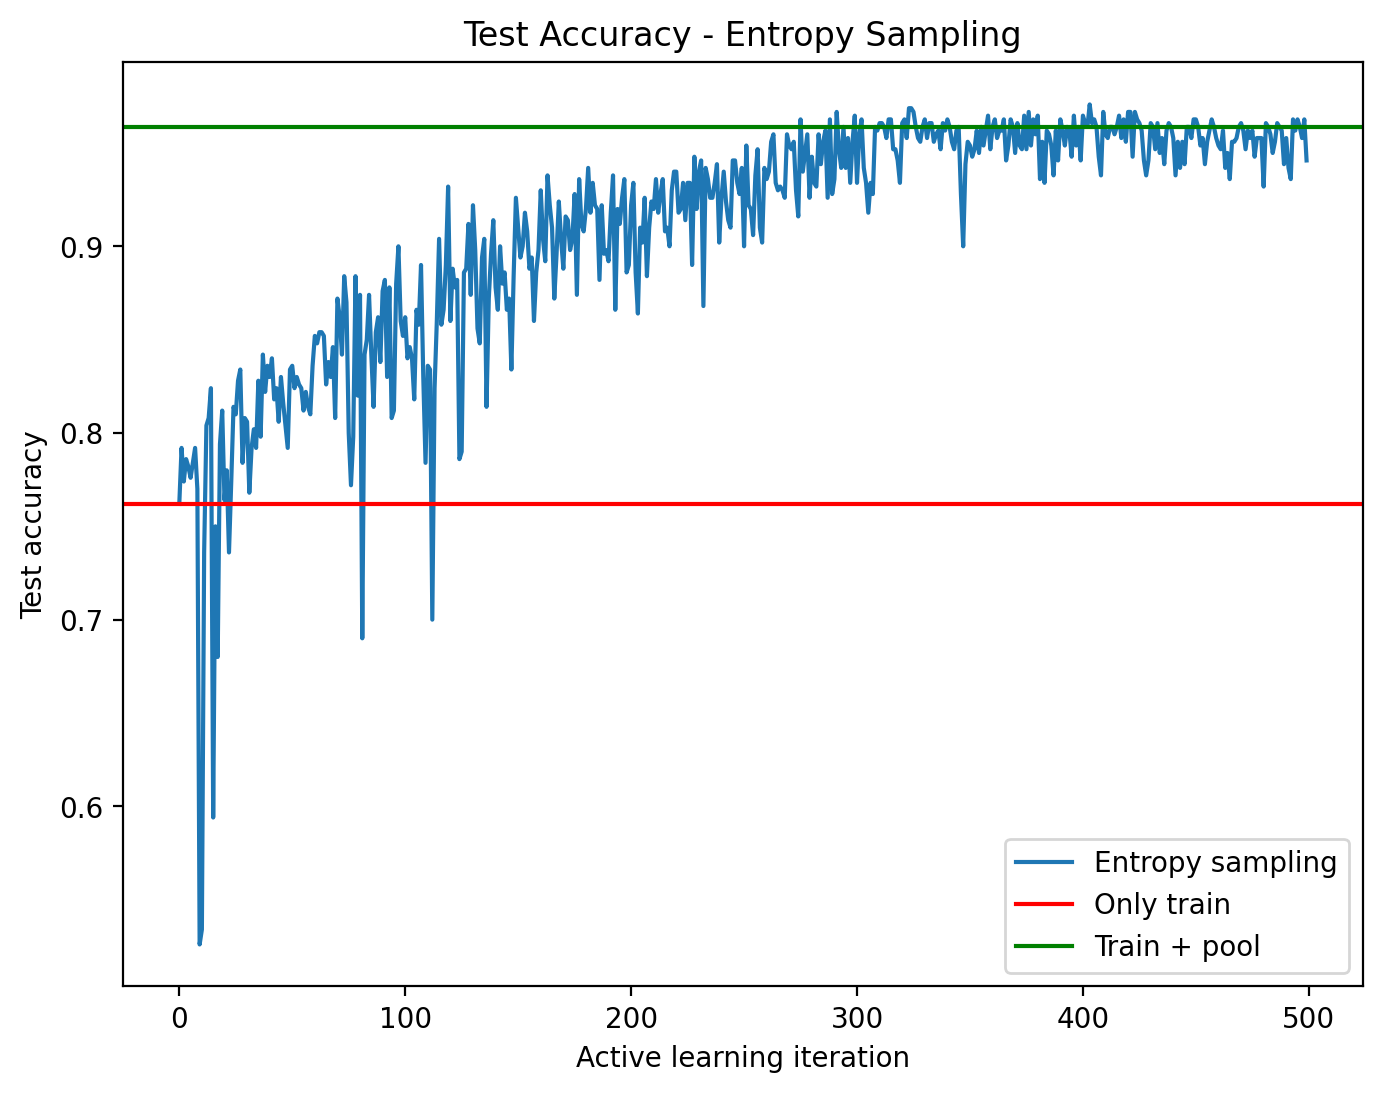

In [13]:

strategy_name = 'Entropy sampling'
strategy_fn = strategies[strategy_name]

print(f"\nRunning strategy: {strategy_name}")
accuracies, _ = run_active_learning(X_labeled, y_labeled, X_pool, y_pool, X_train, y_train, X_test, y_test,
                                   strategy_fn, strategy_name, num_iterations, samples_per_iteration=1)
results['Entropy sampling'] = pd.Series(accuracies, index=range(num_iterations))


print("\n")
plt.figure(figsize=(8, 6))
pd.Series(accuracies).plot(label="Entropy sampling")
plt.axhline(accuracy_only_train, color='r', label='Only train')
plt.axhline(accuracy_train_plus_pool, color='g', label='Train + pool')
plt.xlabel("Active learning iteration")
plt.ylabel("Test accuracy")
plt.title("Test Accuracy - Entropy Sampling")
plt.legend()
plt.show()

<h2>Acquistion Function 3: <b>Margin Sampling</b</h2>


Running strategy: Margin sampling

Strategy: Margin sampling
Final model - Test accuracy: 0.9600


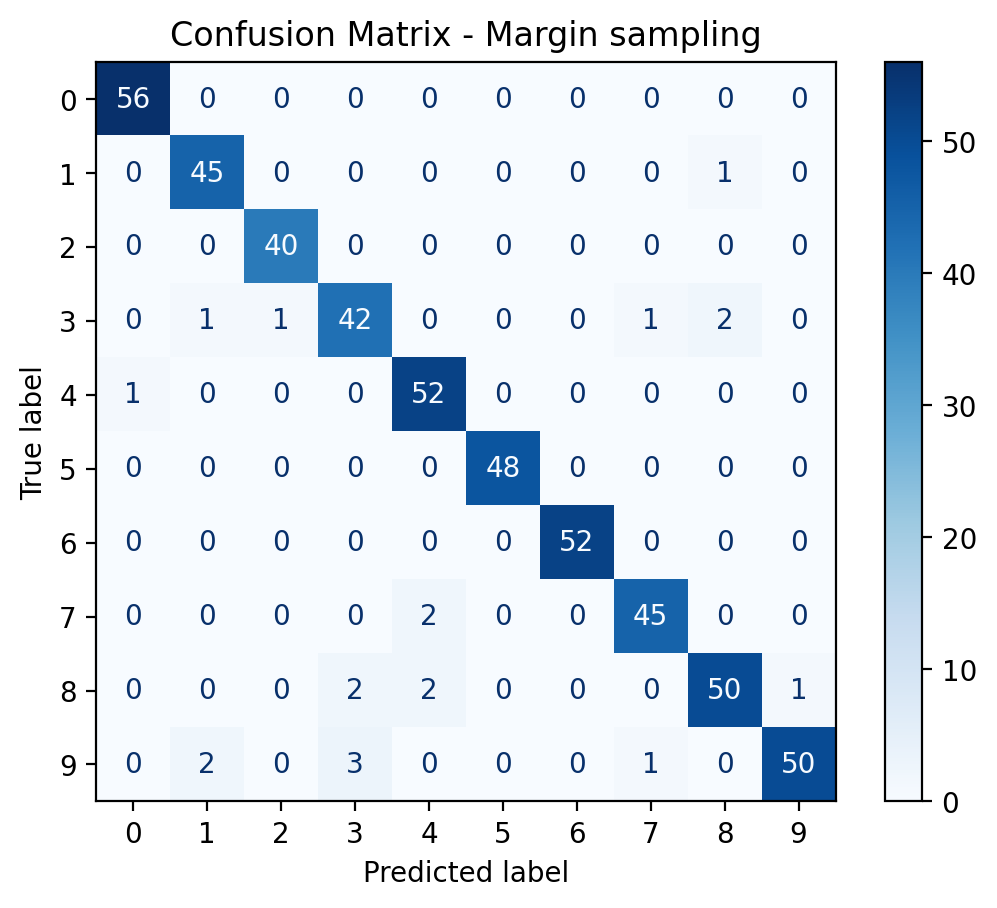

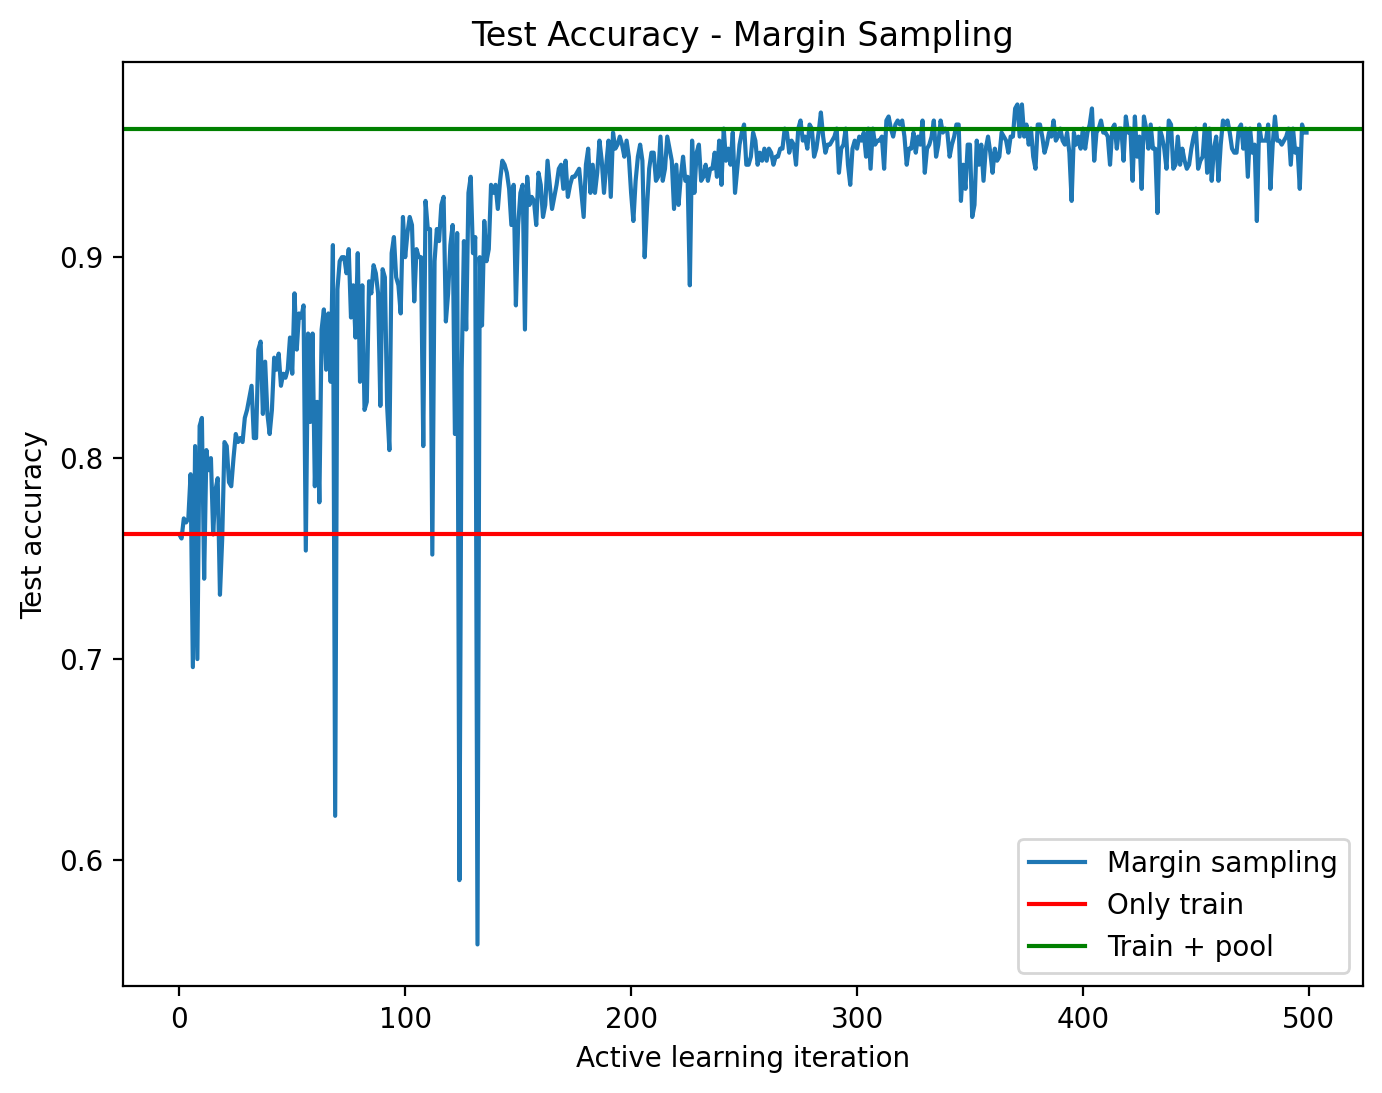

In [14]:

strategy_name = 'Margin sampling'
strategy_fn = strategies[strategy_name]

print(f"\nRunning strategy: {strategy_name}")
accuracies, _ = run_active_learning(X_labeled, y_labeled, X_pool, y_pool, X_train, y_train, X_test, y_test,
                                   strategy_fn, strategy_name, num_iterations, samples_per_iteration=1)
results['Margin sampling'] = pd.Series(accuracies, index=range(num_iterations))


print("\n")
plt.figure(figsize=(8, 6))
pd.Series(accuracies).plot(label="Margin sampling")
plt.axhline(accuracy_only_train, color='r', label='Only train')
plt.axhline(accuracy_train_plus_pool, color='g', label='Train + pool')
plt.xlabel("Active learning iteration")
plt.ylabel("Test accuracy")
plt.title("Test Accuracy - Margin Sampling")
plt.legend()
plt.show()

<h2><b>Overall plot</h2>

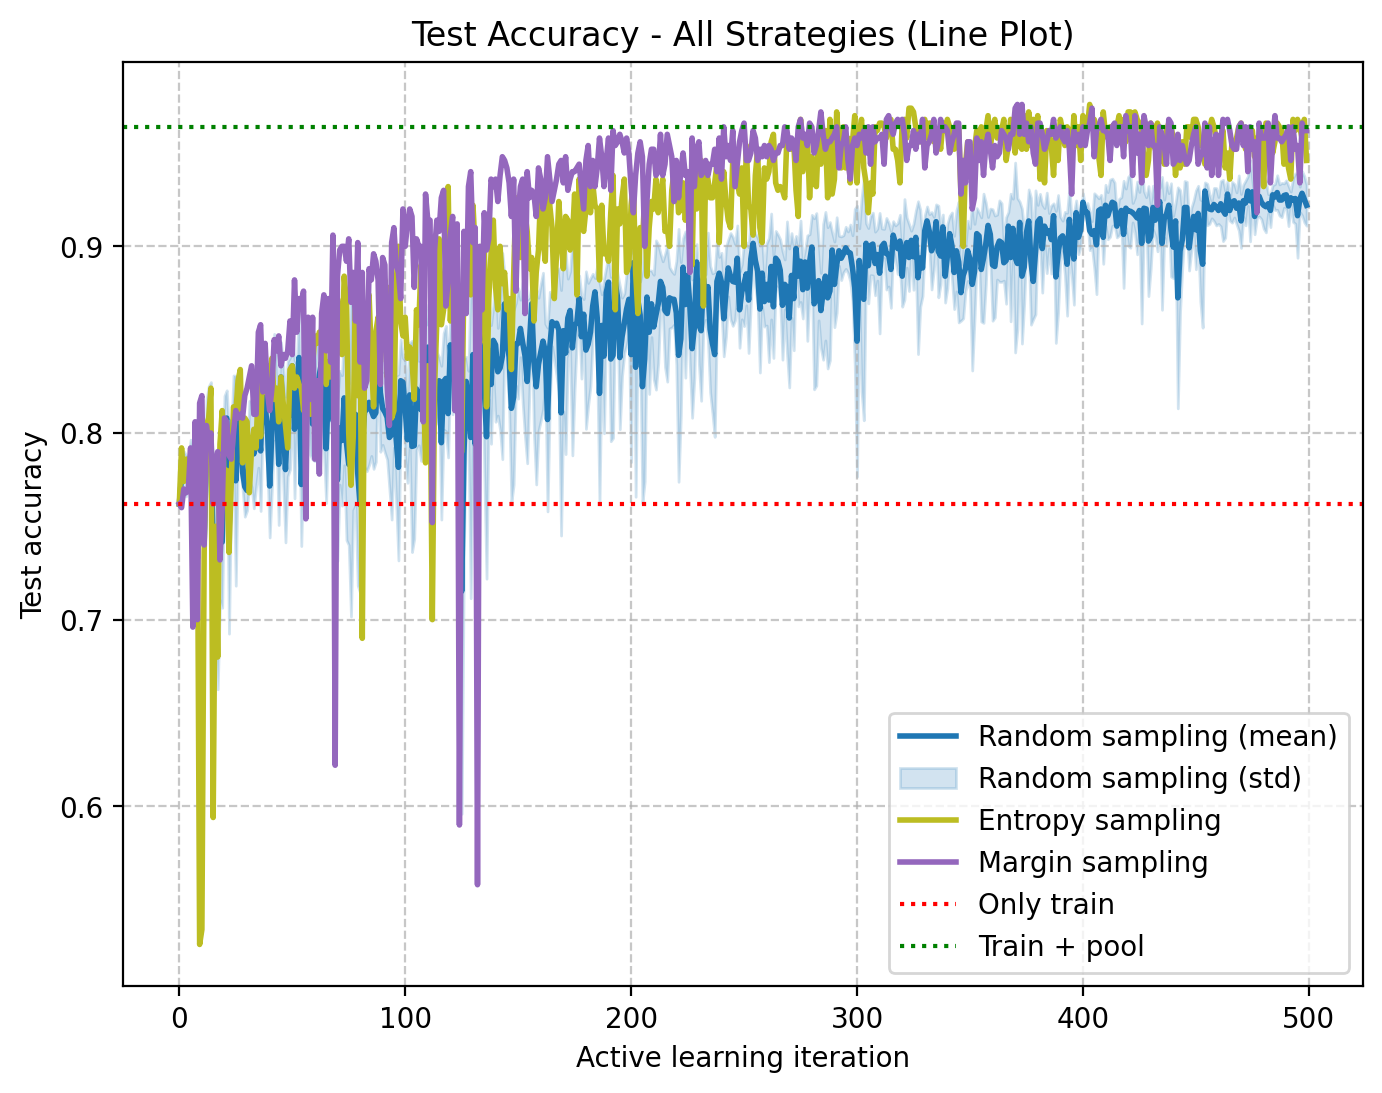

In [15]:

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(results['Random sampling'], label="Random sampling (mean)", linestyle='-', color='C0', linewidth=2)
ax.fill_between(results['Random sampling'].index, results['Random sampling']- std_acc, results['Random sampling']+std_acc, alpha=0.2, label="Random sampling (std)",color='C0')
ax.plot(results['Entropy sampling'], label="Entropy sampling", linestyle='-', color='C8', linewidth=2)
ax.plot(results['Margin sampling'], label="Margin sampling", linestyle='-', color='C4', linewidth=2)


ax.axhline(accuracy_only_train, color='r', linestyle=':', label='Only train')
ax.axhline(accuracy_train_plus_pool, color='g', linestyle=':', label='Train + pool')

ax.set_xlabel("Active learning iteration")
ax.set_ylabel("Test accuracy")
ax.set_title("Test Accuracy - All Strategies (Line Plot)")
ax.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Introduction to modAL: A Python Library for Active Learning

**modAL** is an open-source Python library designed for implementing active learning workflows. modAL provides a modular and flexible framework to integrate active learning strategies with scikit-learn-compatible models, making it accessible for researchers and practitioners.


It simplifies the implementation of active learning by providing a high-level interface to define learners, query strategies, and iterative learning loops.

 Learn more about it [here][modAL-docs].

[modAL-docs]: https://modal-python.readthedocs.io "modAL Python Documentation"

## Getting Started
To use modAL, install it via pip


<h1><b>

In [16]:
!pip install modAL-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 3.2 MB/s eta 0:00:00


In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.deprecation")

from sklearn.datasets import load_digits
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling





In [18]:

digits = load_digits()
X_raw, y_raw = digits.data, digits.target


print("Dataset: Digits")
print(f"Total number of samples: {len(X_raw)}")
print(f"Shape of images: {X_raw.shape[1]} (8x8 pixel images flattened to 64 features)")
print(f"Number of classes: {len(np.unique(y_raw))} (digits 0-9)")
print(f"Dtype of images: {X_raw.dtype}")
print(f"Dtype of labels: {y_raw.dtype}")



Dataset: Digits
Total number of samples: 1797
Shape of images: 64 (8x8 pixel images flattened to 64 features)
Number of classes: 10 (digits 0-9)
Dtype of images: float64
Dtype of labels: int64


In [19]:
def load_and_split_data():

    digits = load_digits()
    X, y = digits.data, digits.target

    scaler = StandardScaler()
    X = scaler.fit_transform(X)


    indices = np.random.permutation(len(X))
    train_idx = indices[:1297]
    test_idx = indices[1297:]

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]


    train_indices = np.random.permutation(len(X_train))
    labeled_indices = train_indices[:100]
    pool_indices = train_indices[100:]

    X_labeled = X_train[labeled_indices]
    y_labeled = y_train[labeled_indices]
    X_pool = X_train[pool_indices]
    y_pool = y_train[pool_indices]

    print(f"Initial labeled set size: {len(X_labeled)}")
    print(f"Pool set size: {len(X_pool)}")
    print(f"Test set size: {len(X_test)}")

    return X_labeled, y_labeled, X_pool, y_pool, X_train, y_train, X_test, y_test, scaler

X_labeled, y_labeled, X_pool, y_pool, X_train, y_train, X_test, y_test, scaler = load_and_split_data()

Initial labeled set size: 100
Pool set size: 1197
Test set size: 500


In [20]:
def compute_baselines(X_labeled, y_labeled, X_pool, y_pool, X_train, y_train, X_test, y_test):

    model = MLPClassifier(
        hidden_layer_sizes=(20,),
        max_iter=2000,
        learning_rate_init=0.01,
        early_stopping=True,
        random_state=42
    )


    model.fit(X_labeled, y_labeled)
    accuracy_only_train = accuracy_score(y_test, model.predict(X_test))
    print(f"Baseline - Only train accuracy: {accuracy_only_train:.4f}")


    X_all = np.concatenate([X_labeled, X_pool])
    y_all = np.concatenate([y_labeled, y_pool])
    model.fit(X_all, y_all)
    accuracy_train_plus_pool = accuracy_score(y_test, model.predict(X_test))
    print(f"Baseline - Train + pool accuracy: {accuracy_train_plus_pool:.4f}")

    return accuracy_only_train, accuracy_train_plus_pool

accuracy_only_train, accuracy_train_plus_pool = compute_baselines(X_labeled, y_labeled, X_pool, y_pool, X_train, y_train, X_test, y_test)

Baseline - Only train accuracy: 0.6560
Baseline - Train + pool accuracy: 0.9420


In [21]:
def run_active_learning_modAL(X_labeled, y_labeled, X_pool, y_pool, X_test, y_test, query_strategy, strategy_name, num_queries=500):

    learner = ActiveLearner(
        estimator=MLPClassifier(
            hidden_layer_sizes=(20,),
            max_iter=2000,
            learning_rate_init=0.01,
            early_stopping=True,
            random_state=42
        ),
        query_strategy=query_strategy,
        X_training=X_labeled,
        y_training=y_labeled
    )

    accuracies = []

    for iteration in range(num_queries):

        test_acc = accuracy_score(y_test, learner.predict(X_test))
        accuracies.append(test_acc)


        if len(X_pool) == 0:
            accuracies.extend([test_acc] * (num_queries - len(accuracies)))

            break

        n_instances = min(1, len(X_pool))
        query_idx, _ = learner.query(X_pool, n_instances=n_instances)


        learner.teach(X_pool[query_idx], y_pool[query_idx])


        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)


        # print(f"Iteration {iteration + 1}: Labeled set size: {len(learner.X_training)}, Pool set size: {len(X_pool)}")

    return accuracies

In [22]:
results = {}

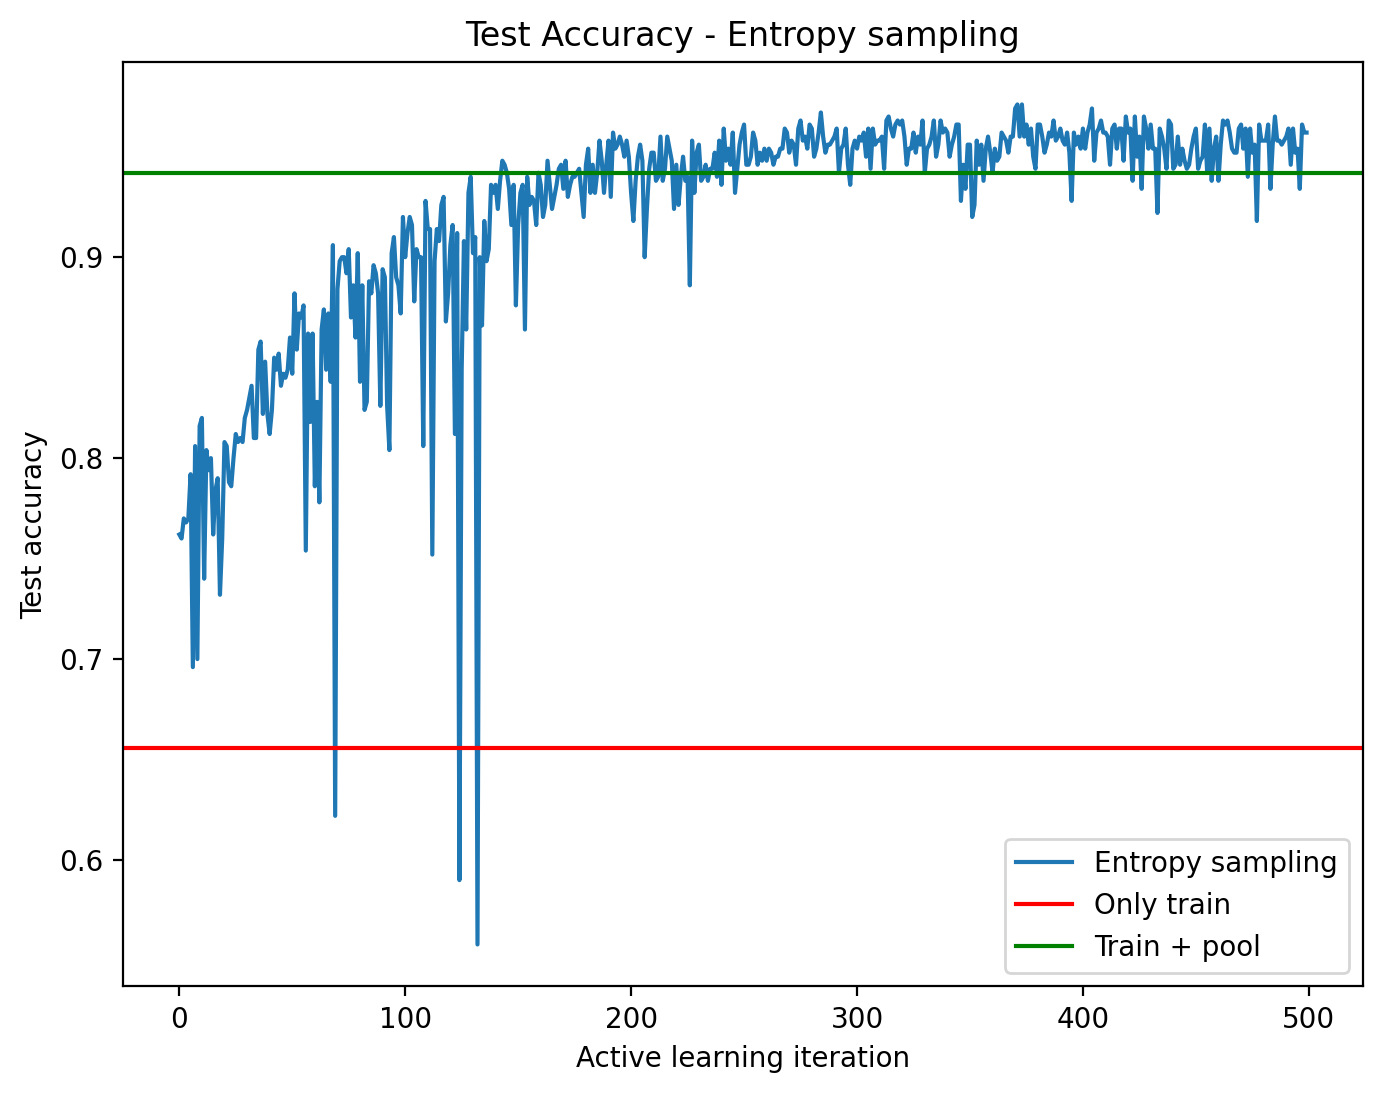

In [23]:


strategy_name = 'Entropy sampling'


accuracies_entropy = run_active_learning_modAL(X_labeled, y_labeled, X_pool.copy(), y_pool.copy(), X_test, y_test,
                                       query_strategy=entropy_sampling, strategy_name=strategy_name, num_queries=500)
results[strategy_name] = accuracies_entropy


plt.figure(figsize=(8, 6))
plt.plot(accuracies, label=strategy_name)
plt.axhline(accuracy_only_train, color='r', label='Only train')
plt.axhline(accuracy_train_plus_pool, color='g', label='Train + pool')
plt.xlabel("Active learning iteration")
plt.ylabel("Test accuracy")
plt.title(f"Test Accuracy - {strategy_name}")
plt.legend()
plt.show()

<h2>Time for Handson</h2>

# Hands-On with modAL: Margin Sampling Strategy

For a hands-on activity visit the [modAL uncertainity measurement page][margin-sampling] to dive into the details and refernce  the example code of entropy sampling provided here.


[margin-sampling]: https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html

Implement  the above Active Learning uisng Margin Sampling technique  and plot the test accuracy  results


In [25]:

strategy_name = 'Margin Sampling'

accuracies_margin = run_active_learning_modAL(X_labeled, y_labeled, X_pool.copy(), y_pool.copy(), X_test, y_test,
                                       query_strategy=margin_sampling, strategy_name=strategy_name, num_queries=500)
results[strategy_name] = accuracies_margin


plt.figure(figsize=(8, 6))
plt.plot(accuracies, label=strategy_name)
plt.axhline(accuracy_only_train, color='r', label='Only train')
plt.axhline(accuracy_train_plus_pool, color='g', label='Train + pool')
plt.xlabel("Active learning iteration")
plt.ylabel("Test accuracy")
plt.title(f"Test Accuracy - {strategy_name}")
plt.legend()
plt.show()

TypeError: margin_sampling() got an unexpected keyword argument 'n_instances'